# Logistic Regression with Wisconsin Breast Cancer Dataset

In [1]:
from sklearn.datasets import load_breast_cancer

In [2]:
data = load_breast_cancer()
print(dir(data))

## Business Understanding

In [4]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Every sample contains features of the nuclei (plural form on nucleus) of a person. Malignant cases are considered dangerous or potential cancer. Benign cases are considered harmless.

## Data Understanding

### Description of the data

There are in total 569 samples, each containing 30 numeric features. 212 samples are labeled as malignant (0) and the remaining 357 samples are considered benign (1).

The first 10 features contain the mean values of the characteristics of the nuclei. The next 10 features contain the standard error values of the characteristics. Lastly, the final 10 features contain the worst cases.

With the check below, we can do a quick check if there are any missing values in the dataset. If there is a `NaN` value in the dataset, the sum of the data will also be `NaN`. So, if the output of the cell below is `True`, there is at least one missing value in the dataset.

In [6]:
import numpy as np

np.isnan(np.sum(data.data))

False

The output is `False`. Therefore, there are no `NaN` values in the dataset.

### Feature characteristics

For every feature, the mean and standard deviation is calculated below.

In [7]:
X = data.data
y = data.target
feature_names = data.feature_names

for i in range(X.shape[1]):
    mean = round(np.mean(X[:, i]), 2)
    std = round(np.std(X[:, i]), 2)
    print(data.feature_names[i])
    print("Mean:", mean)
    print("Standard deviation:", std)
    print()

mean radius
Mean: 14.13
Standard deviation: 3.52

mean texture
Mean: 19.29
Standard deviation: 4.3

mean perimeter
Mean: 91.97
Standard deviation: 24.28

mean area
Mean: 654.89
Standard deviation: 351.6

mean smoothness
Mean: 0.1
Standard deviation: 0.01

mean compactness
Mean: 0.1
Standard deviation: 0.05

mean concavity
Mean: 0.09
Standard deviation: 0.08

mean concave points
Mean: 0.05
Standard deviation: 0.04

mean symmetry
Mean: 0.18
Standard deviation: 0.03

mean fractal dimension
Mean: 0.06
Standard deviation: 0.01

radius error
Mean: 0.41
Standard deviation: 0.28

texture error
Mean: 1.22
Standard deviation: 0.55

perimeter error
Mean: 2.87
Standard deviation: 2.02

area error
Mean: 40.34
Standard deviation: 45.45

smoothness error
Mean: 0.01
Standard deviation: 0.0

compactness error
Mean: 0.03
Standard deviation: 0.02

concavity error
Mean: 0.03
Standard deviation: 0.03

concave points error
Mean: 0.01
Standard deviation: 0.01

symmetry error
Mean: 0.02
Standard deviation: 0.

The values vary from very small values (1e-2) to large values (1e2). Normalizing the values between 0 and 1 is therefore necessary.

### Feature correlations
It is possible that there are features that are highly correlated with other features. If a feature is highly correlated with another feature, it will not contribute anything extra to the model. In the cell below, the Person correlation coefficient between a feature and all other features that are highly correlated with it, are displayed.

In [8]:
high_coeff_thld = 0.8

all_coeff = np.corrcoef(X, rowvar=False)
for i in range(len(feature_names)):
    coeff = all_coeff[i]
    high_coeff_idx = np.argwhere((coeff > high_coeff_thld) & (coeff < 0.999999))
    print(feature_names[i].upper().center(50, '*'))
    print("is highly correlated with the following features")
    print("-"*50)
    for idx in high_coeff_idx:
        print(f"{feature_names[idx][0]} ({np.round_(coeff[idx][0], 3)})")
    print()

*******************MEAN RADIUS********************
is highly correlated with the following features
--------------------------------------------------
mean perimeter (0.998)
mean area (0.987)
mean concave points (0.823)
worst radius (0.97)
worst perimeter (0.965)
worst area (0.941)

*******************MEAN TEXTURE*******************
is highly correlated with the following features
--------------------------------------------------
worst texture (0.912)

******************MEAN PERIMETER******************
is highly correlated with the following features
--------------------------------------------------
mean radius (0.998)
mean area (0.987)
mean concave points (0.851)
worst radius (0.969)
worst perimeter (0.97)
worst area (0.942)

********************MEAN AREA*********************
is highly correlated with the following features
--------------------------------------------------
mean radius (0.987)
mean perimeter (0.987)
mean concave points (0.823)
area error (0.8)
worst radius (0.963)
w

## Data Preparation

The data can be considered already prepared. The only remaining transformation that is required is normalization. Before doing so, the data will be shuffled and the test set will be isolated from the training and evaluation set.

In [9]:
X_y = np.append(X, y.reshape(-1, 1), axis=1)
np.random.shuffle(X_y)

In [10]:
split_trainval_test = 0.2
n = X_y.shape[0]
n_test = int(n * split_trainval_test)
X_y_test = X_y[:n_test]
X_y_trainval = X_y[n_test:]

In [11]:
X_test = X_y_test[:, :-1]
y_test = X_y_test[:, -1]

X_trainval = X_y_trainval[:, :-1]
y_trainval = X_y_trainval[:, -1]

The values are normalized to values between 0 and 1 per feature below.

In [12]:
for i in range(X_trainval.shape[1]):
    vals = X_trainval[:, i]
    X_trainval[:, i] = (vals - np.min(vals))/np.ptp(vals)

In [13]:
X_val = X_trainval[:n_test]
X_train = X_trainval[n_test:]
y_val = y_trainval[:n_test]
y_train = y_trainval[n_test:]

## Modeling

In this section the weights and model are initialized and then trained using batch gradient descent.

In [110]:
w = np.zeros(X_train.shape[1])
b = 1
linear_func = np.dot(X_train, w) + b

In [111]:
f = 1/(1+np.exp(-linear_func))
alpha = 0.1
n_epoch = 2000

In [112]:
def cost_func(f, y):
    total_cost = 0
    m = y.shape[0]
    for i in range(m):
        total_cost += (y[i]*np.log(f[i])) + ((1-y[i])*np.log(1-f[i]))
    return -(1/m)*total_cost

def cost_func_dv(f, y, x, n):
    cost_weights = (1/n) * ((f - y_train) * x).sum()
    cost_bias = (1/n) * (f - y_train).sum()
    return (cost_weights, cost_bias)

In [ ]:
history = []

In [117]:
for epoch in range(n_epoch):
    new_w = []
    for j in range(w.shape[0]):
        n = X_train.shape[0]
        w_cost = (1/n) * ((f - y_train) * X_train[:, j]).sum()
        b_cost = (1/n) * (f - y_train).sum()
        
        new_w.append(w[j] - alpha * w_cost)
        b_temp = w[j] - alpha * b_cost

    w = np.array(new_w)
    b = b_temp
    linear_func = np.dot(X_train, w) + b
    f = 1/(1+np.exp(-linear_func))
    
    cost_train = cost_func(f, y_train)
    cost_val = cost_func(f, y_val)
    history.append(((w, b), cost_train, cost_val))

print("Cost training:", cost_train)
print("Cost validation:", cost_val)

Cost training: 0.24185040882721648
Cost validation: 1.2002218513803895


In [118]:
weights_biases_h = [x[0] for x in history]
cost_train_h = [x[1] for x in history]
cost_val_h = [x[2] for x in history]

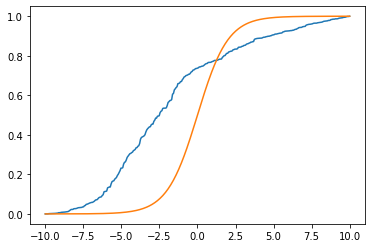

In [119]:
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, X_train.shape[0])
logit = []
for i in x:
    logit.append(1/(1+np.exp(-i)))

plt.plot(x, sorted(f))
plt.plot(x, logit)
plt.show()

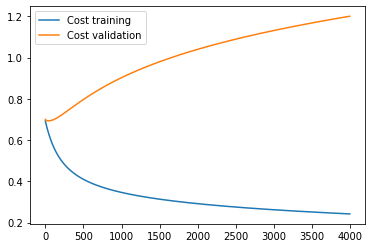

In [120]:
epochs = list(range(len(history)))
plt.plot(epochs, cost_train_h, label="Cost training")
plt.plot(epochs, cost_val_h, label="Cost validation")
plt.legend()
plt.show()